**1. Descriptive Statistics: Calculate and present descriptive statistics for visit_duration_minutes (mean, median, standard deviation, min, max).**

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the dataset
try:
    df = pd.read_csv('../data/processed/visits_cleaned.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'data/processed/visits.csv' not found.")
    print("Please generate the dataset first by running 'python scripts/data_generator.py' from the project root.")
    df = None

if df is not None:
    print("--- Descriptive Statistics for Visit Duration (minutes) ---")
    print(df['visit_duration_minutes'].describe())

Dataset loaded successfully.
--- Descriptive Statistics for Visit Duration (minutes) ---
count    133.000000
mean      53.586466
std       20.411720
min       21.000000
25%       36.000000
50%       53.000000
75%       74.000000
max       90.000000
Name: visit_duration_minutes, dtype: float64


**2. Average visit duration across all services**

In [49]:
if df is not None:
    # Calculate the average visit duration per service type
    average_duration_by_service = df.groupby('service_type')['visit_duration_minutes'].mean().reset_index()
    
    print("\n--- Average Visit Duration by Service Type ---")
    print(average_duration_by_service)


--- Average Visit Duration by Service Type ---
                service_type  visit_duration_minutes
0           General Check-up               54.718750
1                 IV Therapy               56.000000
2  Medication Administration               55.852941
3           Physical Therapy               54.173913
4                 Wound Care               49.527778


**3. service types with the longest and shortest average durations**

In [50]:
if df is not None:
    # Sort the results to easily find the longest and shortest durations
    sorted_durations = average_duration_by_service.sort_values(by='visit_duration_minutes')

    # Identify the service with the shortest average duration
    shortest_duration_service = sorted_durations.iloc[0]
    
    # Identify the service with the longest average duration
    longest_duration_service = sorted_durations.iloc[-1]

    print("\n--- Longest and Shortest Average Visit Durations ---")
    print(f"Service with the shortest average duration: '{shortest_duration_service['service_type']}' ({shortest_duration_service['visit_duration_minutes']:.2f} minutes)")
    print(f"Service with the longest average duration: '{longest_duration_service['service_type']}' ({longest_duration_service['visit_duration_minutes']:.2f} minutes)")


--- Longest and Shortest Average Visit Durations ---
Service with the shortest average duration: 'Wound Care' (49.53 minutes)
Service with the longest average duration: 'IV Therapy' (56.00 minutes)


**4. Any significant difference in visit durations across different visit_location zones**


--- Analysis of Visit Duration by Location ---
Visualizing visit duration distributions by location...


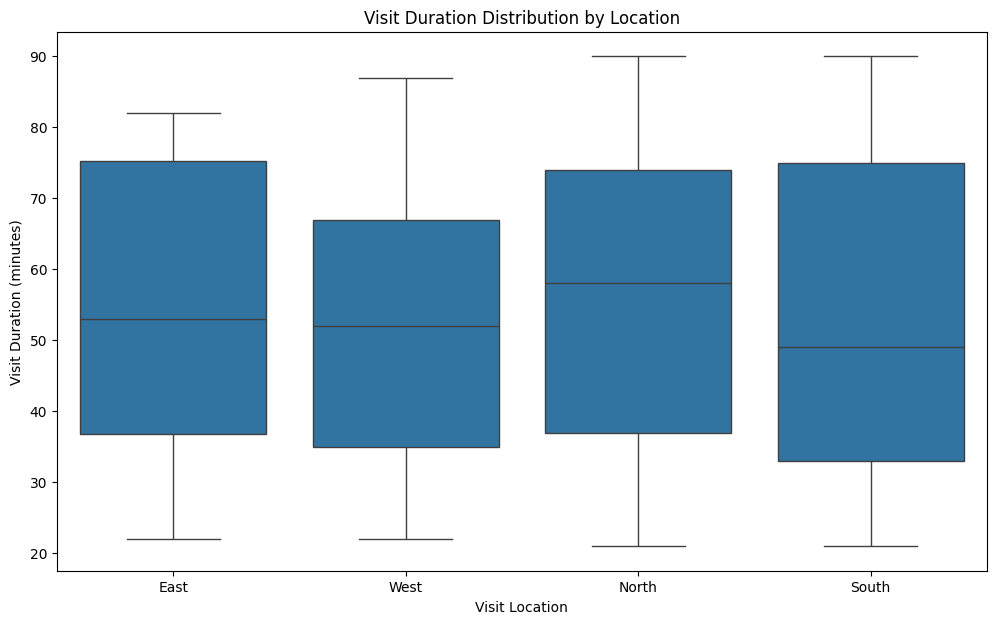


ANOVA Test Results:
F-statistic: 0.1404
P-value: 0.9356

Conclusion: The p-value is greater than or equal to 0.05, so we fail to reject the null hypothesis.
There is no statistically significant difference in mean visit durations across the different locations.


In [57]:
if df is not None:
    print("\n--- Analysis of Visit Duration by Location ---")

    # --- 1. Visualization with a Boxplot ---
    print("Visualizing visit duration distributions by location...")
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='visit_location', y='visit_duration_minutes', data=df)
    plt.title('Visit Duration Distribution by Location')
    plt.xlabel('Visit Location')
    plt.ylabel('Visit Duration (minutes)')
    plt.show()

    # --- 2. Statistical Test (ANOVA) ---
    # The ANOVA test checks if there is a significant difference in means across multiple groups.
    # Null Hypothesis (H0): The mean visit duration is the same for all locations.
    # Alternative Hypothesis (H1): At least one location has a different mean visit duration.

    # Prepare data for the test: a list of duration arrays, one for each location
    locations = df['visit_location'].unique()
    duration_by_location = [df['visit_duration_minutes'][df['visit_location'] == loc] for loc in locations]

    # Perform the one-way ANOVA
    f_statistic, p_value = stats.f_oneway(*duration_by_location)

    print(f"\nANOVA Test Results:")
    print(f"F-statistic: {f_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    # --- 3. Interpretation ---
    alpha = 0.05  # Standard significance level
    if p_value < alpha:
        print("\nConclusion: The p-value is less than 0.05, so we reject the null hypothesis.")
        print("There is a statistically significant difference in mean visit durations across the different locations.")
    else:
        print("\nConclusion: The p-value is greater than or equal to 0.05, so we fail to reject the null hypothesis.")
        print("There is no statistically significant difference in mean visit durations across the different locations.")

**5. Top 3 and bottom 3 nurses by average visit duration**

In [52]:
if df is not None:
    print("\n--- Analysis of Visit Duration by Nurse ---")

    # --- 1. Calculate Average Duration per Nurse ---
    # We'll also count their visits to add context.
    avg_duration_by_nurse = df.groupby('nurse_id')['visit_duration_minutes'].agg(['mean', 'count']).reset_index()
    avg_duration_by_nurse.rename(columns={'mean': 'avg_duration', 'count': 'visit_count'}, inplace=True)

    # --- 2. Calculate the Overall Average Duration for Comparison ---
    overall_avg_duration = df['visit_duration_minutes'].mean()
    print(f"Overall average visit duration across all nurses: {overall_avg_duration:.2f} minutes")

    # --- 3. Sort Nurses by Their Average Duration ---
    sorted_nurses = avg_duration_by_nurse.sort_values(by='avg_duration', ascending=False)

    # --- 4. Identify Top 3 and Bottom 3 Nurses ---
    top_3_nurses = sorted_nurses.head(3)
    bottom_3_nurses = sorted_nurses.tail(3)

    # --- 5. Display the Results ---
    print("\n--- Top 3 Nurses (Longest Average Visit Duration) ---")
    print(top_3_nurses)

    print("\n--- Bottom 3 Nurses (Shortest Average Visit Duration) ---")
    print(bottom_3_nurses)


--- Analysis of Visit Duration by Nurse ---
Overall average visit duration across all nurses: 53.59 minutes

--- Top 3 Nurses (Longest Average Visit Duration) ---
  nurse_id  avg_duration  visit_count
1      n21     65.166667            6
5      n25     58.642857           14
3      n23     57.944444           18

--- Bottom 3 Nurses (Shortest Average Visit Duration) ---
  nurse_id  avg_duration  visit_count
8      n28     52.444444            9
7      n27     48.076923           13
6      n26     40.833333           18


**6. Infer insights from the nurse_notes**

In [53]:
if df is not None:
    # Import necessary libraries for text analysis
    from collections import Counter
    import re

    print("\n--- Analysis of Nurse Notes for Insights on Visit Duration ---")

    # --- 1. Keyword Analysis: Check for words indicating complexity ---
    # Define keywords that might suggest a more complex or longer visit
    complexity_keywords = ['complex', 'complication', 'difficult', 'unstable', 'multiple', 'decline', 'emergency']

    # Create a new column to flag if a note contains any of these keywords
    df['contains_complexity_keyword'] = df['nurse_notes'].str.contains('|'.join(complexity_keywords), case=False, na=False)

    # Compare average visit duration based on the presence of these keywords
    avg_duration_by_keyword = df.groupby('contains_complexity_keyword')['visit_duration_minutes'].mean().reset_index()

    print("\n--- Average Visit Duration Based on Complexity Keywords ---")
    print(avg_duration_by_keyword)
    print("\nInsight: This helps quantify if notes mentioning complexity correspond to longer visits.")

    # --- 2. Word Frequency Analysis for Longest vs. Shortest Visits ---
    # Define "short" and "long" visits based on duration quantiles
    short_visit_threshold = df['visit_duration_minutes'].quantile(0.25)
    long_visit_threshold = df['visit_duration_minutes'].quantile(0.75)

    short_visit_notes = df[df['visit_duration_minutes'] <= short_visit_threshold]['nurse_notes']
    long_visit_notes = df[df['visit_duration_minutes'] >= long_visit_threshold]['nurse_notes']

    # Helper function to process text: tokenize, lowercase, and remove common stop words
    def get_word_counts(notes_series):
        # Combine all notes into a single string
        text = ' '.join(notes_series.astype(str))
        # Find all words, convert to lowercase
        words = re.findall(r'\b\w+\b', text.lower())
        # Basic list of stop words to exclude
        stop_words = set(['the', 'a', 'an', 'and', 'or', 'in', 'is', 'it', 'of', 'for', 'on', 'with', 'to', 'was', 'no', 'not'])
        # Filter out stop words and words with less than 3 characters
        filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
        return Counter(filtered_words)

    # Get the most common words for each category
    top_words_short_visits = get_word_counts(short_visit_notes).most_common(10)
    top_words_long_visits = get_word_counts(long_visit_notes).most_common(10)

    print("\n--- Top 10 Most Common Words in Notes for SHORT Visits (<= {:.0f} mins) ---".format(short_visit_threshold))
    print(top_words_short_visits)

    print("\n--- Top 10 Most Common Words in Notes for LONG Visits (>= {:.0f} mins) ---".format(long_visit_threshold))
    print(top_words_long_visits)
    print("\nInsight: Comparing these lists can reveal themes. For example, words like 'assessment', 'monitor', or 'medication' might appear more in long visits, while 'follow-up' or 'stable' might be more common in short ones.")


--- Analysis of Nurse Notes for Insights on Visit Duration ---

--- Average Visit Duration Based on Complexity Keywords ---
   contains_complexity_keyword  visit_duration_minutes
0                        False               53.586466

Insight: This helps quantify if notes mentioning complexity correspond to longer visits.

--- Top 10 Most Common Words in Notes for SHORT Visits (<= 36 mins) ---
[('note', 12), ('provided', 12), ('nothing', 4), ('patient_temp', 3), ('check', 3), ('this', 3), ('add', 3), ('article', 3), ('indeed', 3), ('save', 2)]

--- Top 10 Most Common Words in Notes for LONG Visits (>= 74 mins) ---
[('note', 18), ('provided', 18), ('this', 6), ('patient_temp', 6), ('check', 5), ('bed', 3), ('participant', 3), ('water', 3), ('major', 3), ('create', 2)]

Insight: Comparing these lists can reveal themes. For example, words like 'assessment', 'monitor', or 'medication' might appear more in long visits, while 'follow-up' or 'stable' might be more common in short ones.


--- Descriptive Statistics for Visit Duration (minutes) ---
count    133.000000
mean      53.586466
std       20.411720
min       21.000000
25%       36.000000
50%       53.000000
75%       74.000000
max       90.000000
Name: visit_duration_minutes, dtype: float64

--- Histogram of Visit Durations ---


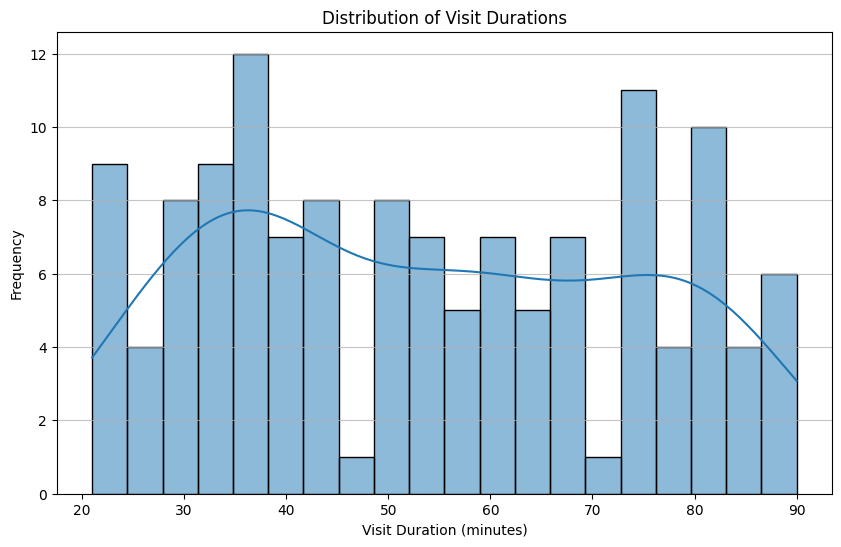

In [54]:
if df is not None:
    print("--- Descriptive Statistics for Visit Duration (minutes) ---")
    print(df['visit_duration_minutes'].describe())
if df is not None:
    # --- Visualize the Distribution of Visit Durations ---
    print("\n--- Histogram of Visit Durations ---")
    plt.figure(figsize=(10, 6))
    sns.histplot(df['visit_duration_minutes'], bins=20, kde=True)
    plt.title('Distribution of Visit Durations')
    plt.xlabel('Visit Duration (minutes)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()
if df is not None:
    # Calculate the average visit duration per service type
    average_duration_by_service = df.groupby('service_type')['visit_duration_minutes'].mean().reset_index()


--- Average Visit Duration by Service Type ---
                service_type  visit_duration_minutes
0           General Check-up               54.718750
1                 IV Therapy               56.000000
2  Medication Administration               55.852941
3           Physical Therapy               54.173913
4                 Wound Care               49.527778


/var/folders/m2/m8xt2gk918jcn12w3p2xldcm0000gn/T/ipykernel_87914/768696130.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='visit_duration_minutes', y='service_type', data=average_duration_by_service.sort_values('visit_duration_minutes', ascending=False), palette='viridis')


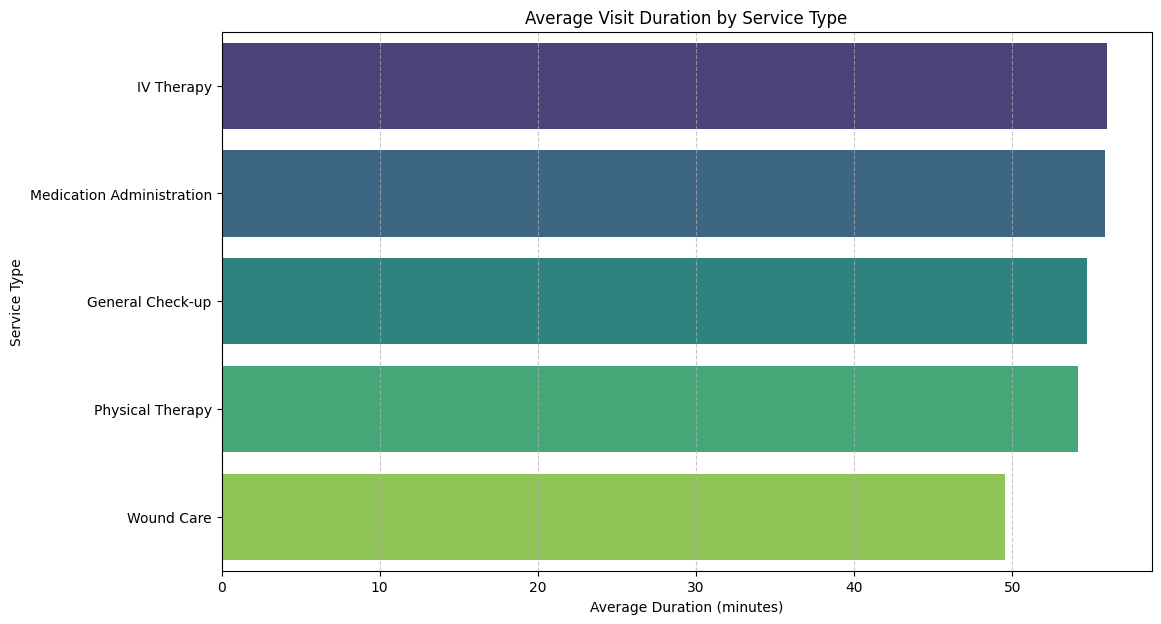


--- Analysis of Visit Duration by Location ---
Visualizing average visit duration by location...


/var/folders/m2/m8xt2gk918jcn12w3p2xldcm0000gn/T/ipykernel_87914/768696130.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='visit_location', y='visit_duration_minutes', data=avg_duration_by_location.sort_values('visit_duration_minutes', ascending=False), palette='plasma')


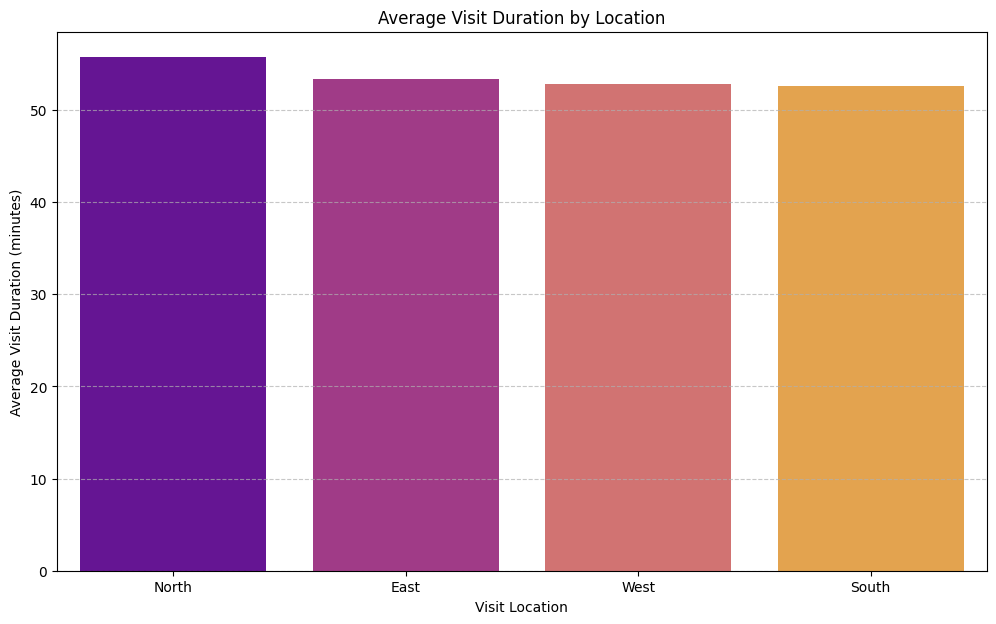

Visualizing visit duration distributions by location...


<Figure size 1200x700 with 0 Axes>

In [55]:
print("\n--- Average Visit Duration by Service Type ---")
print(average_duration_by_service)
if df is not None:
    # --- Visualize Average Duration by Service Type ---
    plt.figure(figsize=(12, 7))
    sns.barplot(x='visit_duration_minutes', y='service_type', data=average_duration_by_service.sort_values('visit_duration_minutes', ascending=False), palette='viridis')
    plt.title('Average Visit Duration by Service Type')
    plt.xlabel('Average Duration (minutes)')
    plt.ylabel('Service Type')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
if df is not None:
    # Sort the results to easily find the longest and shortest durations
    sorted_durations = average_duration_by_service.sort_values(by='visit_duration_minutes')

    print("\n--- Analysis of Visit Duration by Location ---")

    # --- 1. Visualization with Bar and Box Plots ---
    # Calculate average duration by location
    avg_duration_by_location = df.groupby('visit_location')['visit_duration_minutes'].mean().reset_index()

    print("Visualizing average visit duration by location...")
    plt.figure(figsize=(12, 7))
    sns.barplot(x='visit_location', y='visit_duration_minutes', data=avg_duration_by_location.sort_values('visit_duration_minutes', ascending=False), palette='plasma')
    plt.title('Average Visit Duration by Location')
    plt.xlabel('Visit Location')
    plt.ylabel('Average Visit Duration (minutes)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # --- 1. Visualization with a Boxplot ---
    print("Visualizing visit duration distributions by location...")
    plt.figure(figsize=(12, 7))



--- Box Plot of Visit Durations by Service Type ---


/var/folders/m2/m8xt2gk918jcn12w3p2xldcm0000gn/T/ipykernel_87914/2395903027.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='visit_duration_minutes', y='service_type', data=df, palette='viridis')


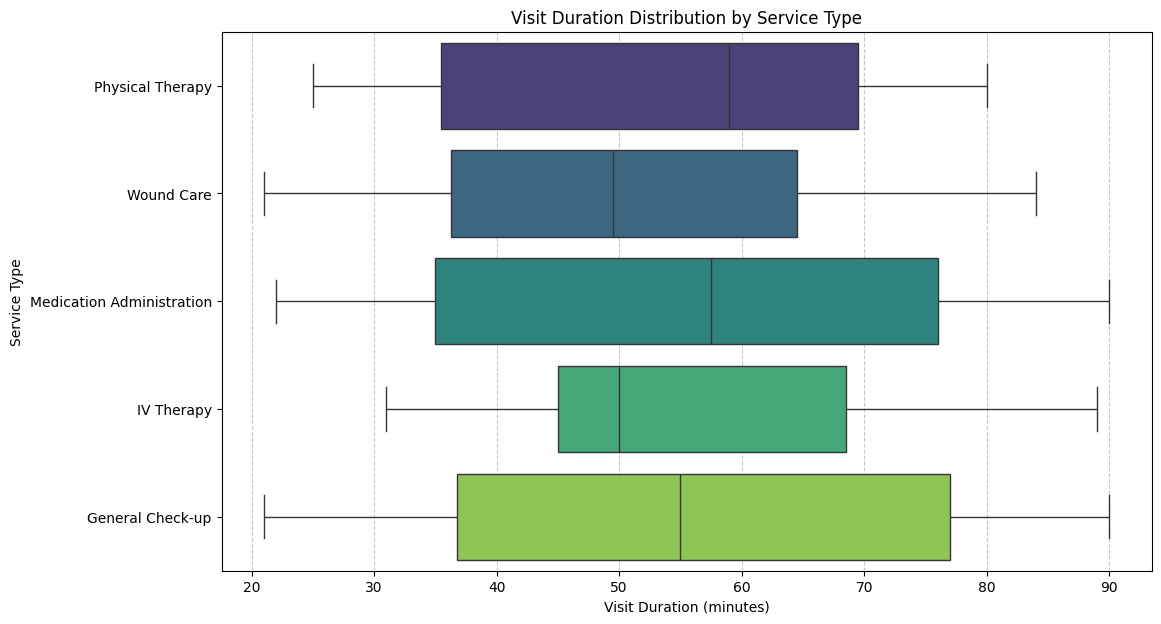

In [56]:
if df is not None:
    # --- Visualize Distribution by Service Type with a Box Plot ---
    print("\n--- Box Plot of Visit Durations by Service Type ---")
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='visit_duration_minutes', y='service_type', data=df, palette='viridis')
    plt.title('Visit Duration Distribution by Service Type')
    plt.xlabel('Visit Duration (minutes)')
    plt.ylabel('Service Type')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
if df is not None:
    # Sort the results to easily find the longest and shortest durations
    sorted_durations = average_duration_by_service.sort_values(by='visit_duration_minutes')